Name: Shiska Raut <br>
ID: 1001526329

In [62]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## Read training/evaluation data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: Each column in the array(s) epresents a single datapoint.

In [63]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    labels = []
    
    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')
            
            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)
            
            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        # convert labels list to array
        Y = np.array(labels, dtype = dtype_y, ndmin = 2)
        
        return X.transpose(), Y

## Read test data

**Argument(s):** 
1) name of a .txt file with each line containing test features(x) in the following format:
(x1, x2, .....xn) <br>
2) dtype_x: datatype of features

**Return(s):** 'X' where X is a numpy array of feature vectors.
Note: Each column in the array(s) epresents a single datapoint.

In [64]:
def get_X_array(filename, dtype_x):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    
    with f:
        line = f.readline()
        while line != '':
            
            # get feature values
            line = line.strip('\n')
            line = line.strip('( )')
            feat = line.split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        return X.transpose()

# 1) Locally Weighted Linear Regression 

### Helper Functions 

In [65]:
# gets sample squared error
def get_sample_squared_error(y_sample, y_pred):
    
    # calculate and return squared error
    return np.square(y_sample - y_pred)


# gets average squared error for an entire test dataset
def get_avg_squared_error(Y_pred, Y_test):

    sum_of_sq_err = np.sum((Y_pred - Y_test)**2, axis = 1)
    
    # return average over number of samples
    return sum_of_sq_err[0]/Y_pred.shape[1]


# gets prediction value for a sample
def get_y_pred_value_lolr(x_sample, model_params):
    
    y_pred = np.dot(model_params, x_sample)

    # return prediction value as a scalar
    return y_pred[0, 0]

# transform training data given gaussian weights
def transform_data(X_train, Y_train, x_point, gamma):

    # # get number of training samples
    n_feat, n_train_samples = X_train.shape

    #initialize array to store weights
    weights = np.zeros((n_feat, n_train_samples), dtype = float)

    for i in range(n_train_samples):
        weights[:,i] = float(np.exp(-((X_train[:,i] - x_point[1])**2)/(2*gamma**2)))    

    # transform data
    X_trans = weights*X_train
    Y_trans = weights*Y_train

    return X_trans, Y_trans    

## 2 a) Model Training & Prediction

In [66]:
# trains a locally weighted linear regression model given a point 'x_point'
def train_model_lolr(X_train, Y_train, x_point, epochs, alpha, gamma):
    
    # use datapoint 'x_point' datapoint to transform data
    X_trans, Y_trans = transform_data(X_train, Y_train, x_point, gamma)
    
    # get number of training samples
    n_feat, n_train_samples = X_trans.shape
    
    # add bias to X
    X_train_b = np.ones((n_feat+1, n_train_samples), dtype = float)
    X_train_b[1,:] = X_trans

    # get output dimension
    n_out, __ = Y_train.shape
    
    # initialize model parameters
    model_params = np.random.uniform(-0.1, 0.1, size = (n_out, n_feat+1))
    
    # do this per epoch
    for i in range(epochs): 
        
        # initialize gradient vector for each epoch
        gradient_vec = np.zeros((n_out, n_feat+1), dtype = float)
        
        # for every training sample
        for j in range(n_train_samples):
             
            x_sample = X_train_b[:,j].reshape(n_feat+1, 1)
            y_sample = Y_trans[:,j]
            
            # get prediction value and adjust weights
            y_pred = get_y_pred_value_lolr(x_sample, model_params)
            
            # sum gradients over all training samples
            gradient_vec = gradient_vec + (y_pred - y_sample[0])*(x_sample.transpose())
            
        # adjust parameter values using batch gradient descent 
        model_params = model_params - (alpha*gradient_vec)
        
    # return final parameter vector
    return model_params


# returns predicted values for an entire test dataset
def get_predictions_lolr(X_train, Y_train, X_test, epochs, alpha, gamma):
    
    # save number of test samples
    n_feat, n_test_samples = X_test.shape

    # add bias to test data
    X_test_b = np.ones((n_feat+1, n_test_samples))
    X_test_b[1,:] = X_test
    
    # store prediction values
    predictions = []

    
    for i in range(n_test_samples):

        # get test sample to train model om
        x_test_sample = X_test_b[:, i].reshape(n_feat+1, 1)
        
        # train model for local parameters
        model_params = train_model_lolr(X_train, Y_train, x_test_sample, epochs, alpha, gamma)
        y_sample_pred = get_y_pred_value_lolr(x_test_sample, model_params)
        predictions.append(y_sample_pred)
    
    # convert list to array
    Y_pred = np.array(predictions, dtype = float, ndmin = 2)
    
    return Y_pred

## 2 b) Function Plotting

To plot the function, a range of x_values is created using the max and min value in the training data and prediction for each datapoint is obtained using locally weighted linear regression and the training data.

In [71]:
# get training data
fname_train = "Data/1_b_c_2_train.txt"
X_train, Y_train = get_X_Y_arrays(fname_train, float, float)

# set paramters
gamma = 0.13
alpha = 0.01
epochs = 200
n_train_samples = X_train.shape[1]

# create range for plotting
X_range = np.linspace(np.amin(X_train), np.amax(X_train)+0.1, n_train_samples)

# get predictions for x_range
Y_range_pred = get_predictions_lolr(X_train, Y_train, X_range.reshape(1, n_train_samples), epochs, alpha, gamma)

#### Plot predictions against training data

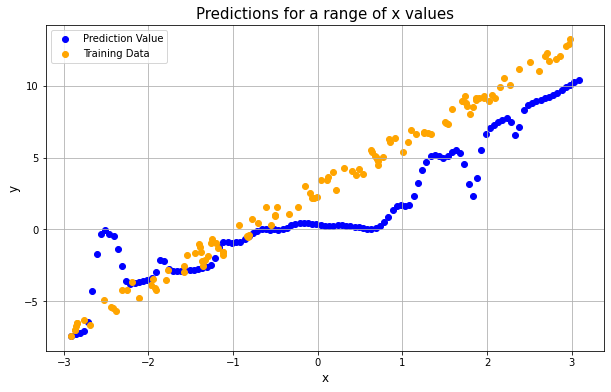

In [91]:
# convert arrays to 1D
X_train_p = X_train.squeeze()
Y_train_p = Y_train.squeeze()
Y_range_pred_p = Y_range_pred.squeeze()

# plot function values VS actual values for training data
fig = plt.figure(figsize = (10, 6))
plt.scatter(X_range, Y_range_pred_p, color = 'blue')
plt.scatter(X_train_p, Y_train_p, color = 'orange')

# add title, labels and legend
plt.legend(['Prediction Value', 'Training Data'], loc = 2)
title_str = f'Predictions for a range of x values'
plt.title(title_str, fontdict = {'fontsize': 15})
plt.xlabel('x', fontdict = {'fontsize': 12})
plt.ylabel('y', fontdict = {'fontsize': 12})
plt.grid()

## 2 c) Evaluation on training and test data

In [73]:
# get data
fname_test = "Data/1_c_test.txt"
X_test, Y_test = get_X_Y_arrays(fname_test, float, float)

# get predictions on test data
Y_test_pred = get_predictions_lolr(X_train, Y_train, X_test, epochs, alpha, gamma)

# get error
average_test_error = get_avg_squared_error(Y_test_pred, Y_test)

print(f'The average sqaured error for {epochs} epochs is {average_test_error:.2f}.\n')

The average sqaured error for 200 epochs is 1.05.



### Plot Y_pred vs Y_test 

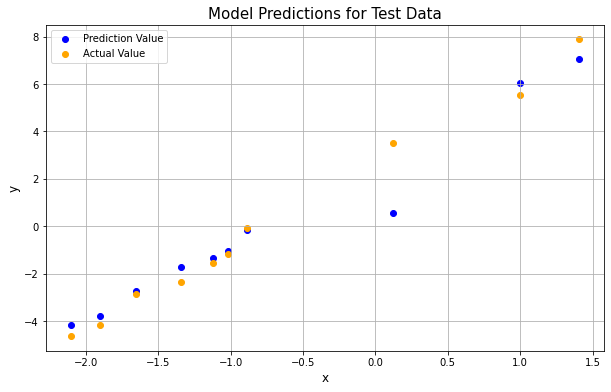

In [90]:
# convert arrays to 1D
X_test_p = X_test.squeeze()
Y_test_p = Y_test.squeeze()
Y_test_pred_p = Y_test_pred.squeeze()

# plot function values VS actual values for training data
fig = plt.figure(figsize = (10, 6))
plt.scatter(X_test_p, Y_test_pred_p, color = 'blue')
plt.scatter(X_test_p, Y_test_p, color = 'orange')

# add title, labels and legend
plt.legend(['Prediction Value', 'Actual Value'], loc = 2)
title_str = f'Model Predictions for Test Data'
plt.title(title_str, fontdict = {'fontsize': 15})
plt.xlabel('x', fontdict = {'fontsize': 12})
plt.ylabel('y', fontdict = {'fontsize': 12})
plt.grid()

### 1 c) Conclusion:
The performance is similar to that of linear regression except in certain regions such as when x_values close to zero. Therefore, the average error for locally weighted linear regression was found to be a bit higher than that of linear regression.

## 2 d)

In [80]:
# get only frist 20 data points fro training
X_train_20 = X_train[:,0:19].reshape(1, 19)
Y_train_20 = Y_train[:,0:19].reshape(1, 19)

# create range for plotting
X_range_20 = np.linspace(np.amin(X_train_20), np.amax(X_train_20)+0.1, n_train_samples)

# get predictions for x_range
Y_range_pred_20 = get_predictions_lolr(X_train_20, Y_train_20, X_range_20.reshape(1, n_train_samples), epochs, alpha, gamma)

### Plot function against training data

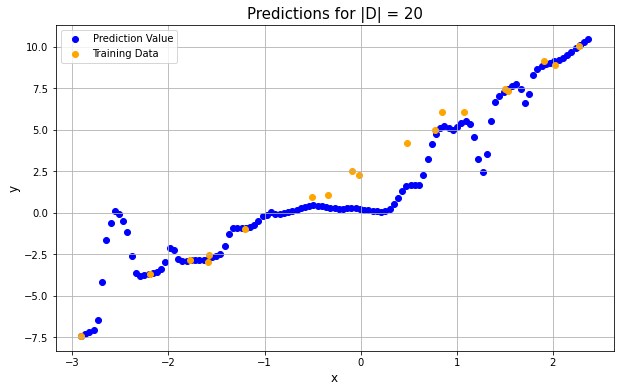

In [89]:
# convert arrays to 1D
X_train_20_p = X_train_20.squeeze()
Y_train_20_p = Y_train_20.squeeze()
Y_range_pred_20_p = Y_range_pred_20.squeeze()

# plot function values VS actual values for training data
fig = plt.figure(figsize = (10, 6))
plt.scatter(X_range_20, Y_range_pred_20_p, color = 'blue')
plt.scatter(X_train_20_p, Y_train_20_p, color = 'orange')

# add title, labels and legend
plt.legend(['Prediction Value', 'Training Data'], loc = 2)
title_str = f'Predictions for a range of x values |D| = 20'
plt.title(title_str, fontdict = {'fontsize': 15})
plt.xlabel('x', fontdict = {'fontsize': 12})
plt.ylabel('y', fontdict = {'fontsize': 12})
plt.grid()

### 2 d) Conclusion 
As shown by the above figure, locally weighted linear regression performs poorly if the dataset in too sparse/small. This is because during training and prediction, only datapoints that are in the surrourding neighborhood described by the gaussian are taken into account. If there are no datapoints or very less datapoints, the model performs poorly in that area. 

In [83]:
# get predictions on test data by only using 20 training data points
Y_test_pred_20 = get_predictions_lolr(X_train_20, Y_train_20, X_test, epochs, alpha, gamma)

# get error
average_test_error_20 = get_avg_squared_error(Y_test_pred_20, Y_test)

print(f'The average sqaured error for {epochs} epochs is {average_test_error_20:.2f}.\n')

The average sqaured error for 200 epochs is 2.01.



### Plot Y_pred vs Y_test 

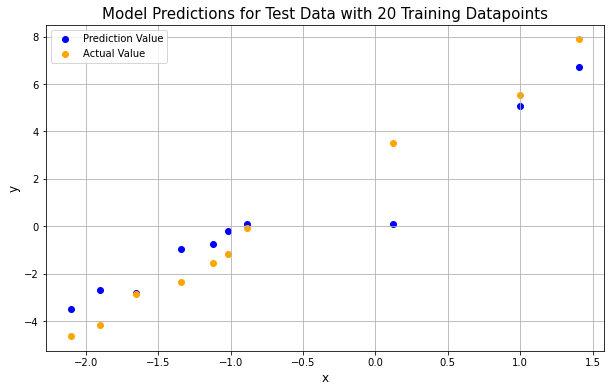

In [93]:
# convert arrays to 1D
X_test_p = X_test.squeeze()
Y_test_p = Y_test.squeeze()
Y_test_pred_20_p = Y_test_pred_20.squeeze()

# plot function values VS actual values for training data
fig = plt.figure(figsize = (10, 6))
plt.scatter(X_test_p, Y_test_pred_20_p, color = 'blue')
plt.scatter(X_test_p, Y_test_p, color = 'orange')

# add title, labels and legend
plt.legend(['Prediction Value', 'Actual Value'], loc = 2)
title_str = f'Model Predictions for Test Data with 20 Training Datapoints'
plt.title(title_str, fontdict = {'fontsize': 15})
plt.xlabel('x', fontdict = {'fontsize': 12})
plt.ylabel('y', fontdict = {'fontsize': 12})
plt.grid()

### 2 d) Conclusion
Taking only 20 training datapoints for training and prediction resulted in a significant increase in test error. This is because decrease in the number of training datapoints means less or no datapoints avaialble in the query point's neighborhood for training and estimation. This may lead to an increase in prediction error.